In [1]:
import json
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import preprocessing

In [2]:
# Function used to encode categorical variables
#Función usada para la codificación a 0 y 1 de variables categóricas
def one_hot_encode(df, feature_name, categories):
    for category in categories:
        new_feature_name = '{}_{}'.format(feature_name, category)
        df[new_feature_name] = (df[feature_name] == category) * 1
    del df[feature_name]

In [3]:
raw_df = pd.read_csv("data.zip")
# I split modeling data
#Separo los datos para evaluacion de kate y los datos de modelación

modelling_df = raw_df[raw_df.evaluation_set == False]



In [4]:
# choose de columns to model
features_for_model_0_1 = ['goal', 'country', 'deadline', 'created_at',
                          'launched_at', 'static_usd_rate', 'category',
                         'profile', 'state']
# genera un dataframe con las columnas seleccionadas para datos q no son evaluacion
reduced_df = modelling_df[features_for_model_0_1]
# Do DataFrame copy
numeric_df = reduced_df.copy()
# crea la columna goal_in_usd con los montos ajustados al cambio
#I Fit the goal money to usd rate
numeric_df['goal_in_usd'] = numeric_df['goal'] * numeric_df['static_usd_rate']
# con del elimina las columnas
# Delete columns that won't be used
del numeric_df['goal']
del numeric_df['static_usd_rate']

#De la columna country separa los datos sin sus repetidos, para luego codificarlos
# I Get unique country
country_categories = numeric_df['country'].unique()
# usar get_dummies no garantiza que me devuelve las misma cantidad de columnas,
#no es recomendado, en este caso se puede usar OneHotEncoder and sklearn columnTransformer
#llama la función para codificar creada arriba
# call function to encode columns
one_hot_encode(numeric_df, 'country', country_categories)
# I built the dates columns
numeric_df['campaign_duration_ms'] = numeric_df['deadline'] - numeric_df['launched_at']
numeric_df['campaign_prep_ms'] = numeric_df['launched_at'] - numeric_df['created_at']
numeric_df['campaign_life_ms'] = numeric_df['deadline'] - numeric_df['created_at']

#I get category and subcategory fields of  a json data type in category column
numeric_df['parent_category'] = numeric_df['category']\
    .apply(lambda x: json.loads(x)['slug'].split('/')[0])
# I get unique datas and encode
parent_categories = numeric_df['parent_category'].unique()
one_hot_encode(numeric_df, 'parent_category', parent_categories)


numeric_df['category_name'] = numeric_df['category']\
    .apply(lambda x: json.loads(x)['slug'].split('/')[1])
category_values = numeric_df['category_name'].unique()
one_hot_encode(numeric_df, 'category_name', category_values)


del numeric_df['category']
#I get state and state_changed_at fields of  a json data type in profile column
numeric_df['profile_state'] = numeric_df['profile']\
    .apply(lambda x: json.loads(x)['state'])
numeric_df['profile_state_changed_at'] = numeric_df['profile']\
    .apply(lambda x: json.loads(x)['state_changed_at'])
del numeric_df['profile']
numeric_df['profile_state'] = (numeric_df['profile_state'] == 'active') * 1
#I built times: update time and created profile time 
numeric_df['tmp1'] = numeric_df['deadline'] - numeric_df['profile_state_changed_at']
numeric_df['tmp2'] = numeric_df['launched_at'] - numeric_df['profile_state_changed_at']
del numeric_df['profile_state_changed_at']

del numeric_df['deadline']
del numeric_df['created_at']
del numeric_df['launched_at']
# Fit date
scaler = MinMaxScaler()
column_names = numeric_df.columns
numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=column_names)
# I get X all the columns less state
# X sin la columna state
X = numeric_df.iloc[:,1:]
# y de entrenamiento con la columna state
# I get y only state column
y = numeric_df.iloc[:,0]

# Clasificación de las métricas
Metrics classification


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1337,
                                                    stratify=y)

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [7]:
# y_hat = y predicta
y_hat = knn.predict(X_test)

In [8]:
#Es el porcentaje total de elementos clasificados correctamente True positive True negative
#Es un valor entre 0 y 1. Cuanto más alto, mejor.
accuracy = (y_hat==y_test).mean()
accuracy

0.74

In [9]:
# analiza promedio de falsos positivos y falsos negativos
# accurancy means
class_accuracy = [(y_hat[y_test==0]==y_test[y_test==0]).mean(),
                  (y_hat[y_test==1]==y_test[y_test==1]).mean()]
print(class_accuracy)
print(sum(np.array(class_accuracy)/2))

[0.7939225053078556, 0.6855573419078242]
0.7397399236078399


In [9]:
# usa GridSearchCV para solucionar overfit problems
# I use GridSearchCV to solve overfit problems
params = {'max_depth': [3,5,7,9,11,13]}
cv = GridSearchCV(estimator=DecisionTreeClassifier(),
                  param_grid=params,
                  cv=5)

cv.fit(X, y)

results = pd.DataFrame(cv.cv_results_)
results = results.sort_values('rank_test_score')
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       0.722419      0.012469         0.010140        0.000690   
4       0.614084      0.007089         0.009587        0.000099   
3       0.518660      0.016493         0.009562        0.000377   
2       0.416355      0.014170         0.009346        0.000224   
1       0.299870      0.013464         0.009622        0.000449   
0       0.211873      0.024252         0.010029        0.000797   

  param_max_depth             params  split0_test_score  split1_test_score  \
5              13  {'max_depth': 13}             0.7654             0.7654   
4              11  {'max_depth': 11}             0.7578             0.7588   
3               9   {'max_depth': 9}             0.7478             0.7474   
2               7   {'max_depth': 7}             0.7358             0.7338   
1               5   {'max_depth': 5}             0.7080             0.7027   
0               3   {'max_depth': 3}             0.6679             0.6612   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
5             0.7600             0.7627             0.7617          0.76304   
4             0.7554             0.7539             0.7518          0.75554   
3             0.7452             0.7464             0.7420          0.74576   
2             0.7330             0.7303             0.7309          0.73276   
1             0.7044             0.7013             0.7019          0.70366   
0             0.6720             0.6613             0.6642          0.66532   

   std_test_score  rank_test_score  
5        0.002111                1  
4        0.002547                2  
3        0.002084                3  
2        0.001995                4  
1        0.002407                5  
0        0.004139                6

In [10]:
cv.best_estimator_.predict(X)

array([0., 0., 1., ..., 1., 0., 1.])

In [12]:
# Genera un dataframe, ranking con las columnas más importantes
#cv.best_estimator_.feature_importances_
# I get the importance of columns
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': cv.best_estimator_.feature_importances_
})
importances.sort_values('importance', ascending=False)

feature  importance
165                     profile_state    0.281166
166                              tmp1    0.134638
0                         goal_in_usd    0.112322
42          category_name_documentary    0.062422
47       category_name_tabletop games    0.058839
73               category_name_shorts    0.057430
63       category_name_product design    0.055328
23                   campaign_prep_ms    0.051796
27              parent_category_music    0.020144
51              category_name_fiction    0.019901
56                 category_name_rock    0.017831
71           category_name_indie rock    0.014990
22               campaign_duration_ms    0.014473
24                   campaign_life_ms    0.013975
68              category_name_hip-hop    0.013370
40           category_name_nonfiction    0.012712
167                              tmp2    0.010534
26         parent_category_publishing    0.008287
81          category_name_video games    0.007816
77         category_name_illustration    0.007394
31            parent_category_fashion    0.006516
28              parent_category_games    0.004154
41       category_name_country & folk    0.002264
1                          country_US    0.001385
53            category_name_art books    0.001365
43       category_name_narrative film    0.001058
32             parent_category_crafts    0.000997
103          category_name_public art    0.000994
59     category_name_children's books    0.000982
113              category_name_poetry    0.000958
102          category_name_photobooks    0.000945
34               parent_category_food    0.000528
39       category_name_movie theaters    0.000452
104               category_name_zines    0.000227
80       category_name_graphic novels    0.000219
132                category_name_kids    0.000212
46      category_name_classical music    0.000191
137         category_name_anthologies    0.000186
157     category_name_literary spaces    0.000179
158         category_name_digital art    0.000159
149              category_name_family    0.000158
2                          country_GB    0.000157
114              category_name_spaces    0.000152
110               category_name_farms    0.000152
35              parent_category_dance    0.000046
122               category_name_blues    0.000000
123            category_name_knitting    0.000000
124        category_name_experimental    0.000000
121         category_name_world music    0.000000
125         category_name_3d printing    0.000000
126              category_name_horror    0.000000
127      category_name_graphic design    0.000000
120       category_name_childrenswear    0.000000
115           category_name_thrillers    0.000000
119               category_name_bacon    0.000000
118       category_name_ready-to-wear    0.000000
117               category_name_latin    0.000000
116               category_name_audio    0.000000
129               category_name_video    0.000000
112         category_name_small batch    0.000000
111           category_name_webcomics    0.000000
109             category_name_fantasy    0.000000
108            category_name_footwear    0.000000
107         category_name_comic books    0.000000
106              category_name_events    0.000000
105         category_name_young adult    0.000000
128        category_name_translations    0.000000
17                         country_NO    0.000000
130    category_name_electronic music    0.000000
131           category_name_calendars    0.000000
3                          country_CA    0.000000
164                category_name_apps    0.000000
163           category_name_taxidermy    0.000000
162              category_name_quilts    0.000000
161            category_name_chiptune    0.000000
160         category_name_residencies    0.000000
159           category_name_workshops    0.000000
156          category_name_embroidery    0.000000
155            category_name_textiles    0.000000
154             category_name_

In [11]:
export_graphviz(cv.best_estimator_, out_file='tree.dot',
                feature_names=X.columns, class_names=['failure','success'])

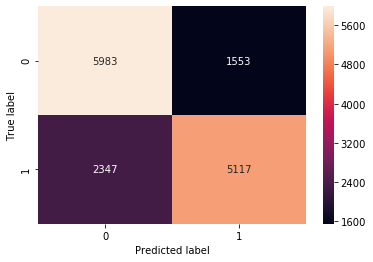

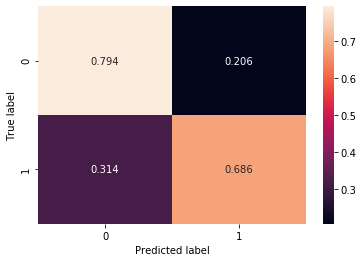

In [12]:
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Bonus: Normalise by row
sns.heatmap(cm/cm.sum(axis=1, keepdims=True), annot=True, fmt='.3f')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

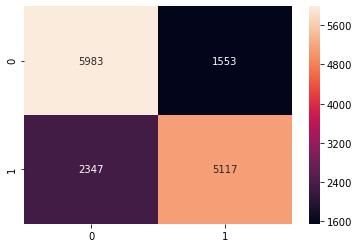

In [13]:
nr_true_positives = sum((y_test==1) & (y_hat==1))
nr_false_positives = sum((y_test==0) & (y_hat==1))
nr_true_negatives = sum((y_test==0) & (y_hat==0))
nr_false_negatives = sum((y_test==1) & (y_hat==0))


manual_cm = np.array([
    [nr_true_negatives, nr_false_positives],
    [nr_false_negatives, nr_true_positives]
])

sns.heatmap(manual_cm, annot=True, fmt='d')

In [14]:
# Get the precision, recall, and f1 score

nr_predicted_positive = nr_true_positives + nr_false_positives
precision = nr_true_positives / nr_predicted_positive
nr_positive_cases = nr_true_positives + nr_false_negatives
recall = nr_true_positives / nr_positive_cases
f1 = 2*(precision*recall) / (precision+recall)
f"Class 1 precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}"

'Class 1 precision: 0.767, recall: 0.686, f1: 0.724'

In [15]:
#Check the values against sklearn.metrics.classification_report
print(classification_report(y_test, y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.718     0.794     0.754      7536
         1.0      0.767     0.686     0.724      7464

    accuracy                          0.740     15000
   macro avg      0.743     0.740     0.739     15000
weighted avg      0.743     0.740     0.739     15000



# Evaluacion y salida probable

In [16]:
def get_fpr_tpr(y, y_pred, thresh):
    # Write a function which gets the false positive rate
    # and true positive rate when given a threshold
 
    nr_positive_cases = sum(y==1)
    nr_negative_cases = sum(y==0)
    y_hat = y_pred >= thresh
    nr_true_positives = sum((y==1) & (y_hat==1))
    nr_false_positives = sum((y==0) & (y_hat==1))
    tpr = nr_true_positives / nr_positive_cases
    fpr = nr_false_positives / nr_negative_cases
    return fpr, tpr


def my_roc_curve(y, y_pred):
    # we need only check a finite number of thresholds
    # get the unique values in y_pred and sort them
    
    thresh = np.sort(np.unique(y_pred))
    
    # Loop through all the thresholds and record the 
    # fpr and tpr in an array
    fpr_array = np.zeros_like(thresh)
    tpr_array = np.zeros_like(thresh)
    for ii, tt in enumerate(thresh):
        fpr, tpr  = get_fpr_tpr(y, y_pred, tt)
        fpr_array[ii] = fpr
        tpr_array[ii] = tpr
    return fpr_array, tpr_array, thresh

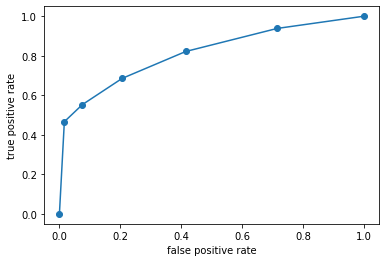

In [17]:
# we can now test this for our knn and plot
y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresh = my_roc_curve(y_test, y_pred)
plt.plot(np.append(fpr, 0), np.append(tpr, 0), 'o-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

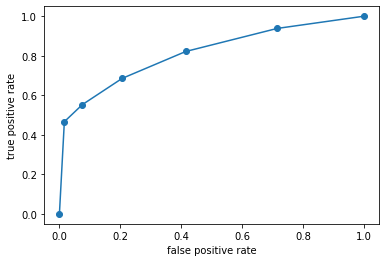

In [18]:
# And we can check it against the sklearn implementation
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'o-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [19]:
roc_auc_score(y_test, y_pred)

0.8125048534451567

In [ ]:

from sklearn.model_selection import GridSearchCV
# Create the dictionary of given parameters

n_neighb = np.arange(1, 10)  
parameters = [{'n_neighbors': n_neighb}] 

#Pass the dicitionary and other parameters to GridSearchCV to create a GridSearchCV object

gridCV = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
gridCV.fit(X_train, y_train)

In [ ]:
#bestNeighb = gridCV.best_params_['n_neighbors']
#print("Best parameters: n_neighbours=", bestNeighb)
#pd.DataFrame(gridCV.cv_results_)
knn = KNeighborsClassifier(n_neighbors=n_neighb)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)


/Users/pola/miniconda3/envs/ads07/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


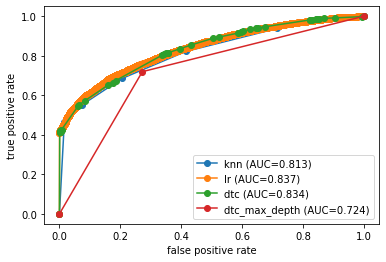

In [23]:
lr =  LogisticRegression()
lr.fit(X_train, y_train)

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train, y_train)

dtc_max = DecisionTreeClassifier(criterion='entropy', max_depth=None)
dtc_max.fit(X_train, y_train)


classifiers = {
    'knn': knn,
    'lr': lr,
    'dtc': dtc,
    'dtc_max_depth': dtc_max
}

for name, clf in classifiers.items():
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, 'o-', label=f"{name} (AUC={auc:.3f})")

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()